https://torch.classcat.com/2018/06/29/keras-ex-tutorials-lstm-time-series-prediction/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import math
import scipy as sp
import statsmodels
%matplotlib inline

np.random.seed(25)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

In [2]:
Macro = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/Macro_ecn.csv' , index_col=0)
Yield = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/bond_yield_add.csv' , index_col=0)
#ここもしかしたらいらないかも？
Macro.index = pd.date_range('1980-1-1', periods=Macro.shape[0], freq='M')
Yield.index = pd.date_range('1980-1-1', periods=Yield.shape[0],freq='M')

In [3]:
Macro=Macro.drop('SPR_1TNFF',axis=1)
Macro['SPR_2TNFF']=Yield['FF']-Yield['2Y']
Macro['SPR_20TNFF']=Yield['FF']-Yield['20Y']
Macro=Macro.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,19,20,22]]
Macro.columns

Index(['R_PCE', 'R_DPI', 'SR', 'HUS', 'IPI_M', 'CUR_M', 'ISM_M', 'MIC_I',
       'MIC_E', 'T_PCEIX', 'C_PCEIX', 'C_CPI', 'C_CPI_INF', 'NFE', 'UR', 'MB',
       'M2', 'R_EFCR', 'SP500', 'SPR_2TNFF', 'SPR_5TNFF', 'SPR_10TNFF',
       'SPR_20TNFF'],
      dtype='object')

In [4]:
Yield[240:].shape
#Yield.tail()

(243, 6)

In [5]:
#Yield.iloc[462:]

In [6]:
#Yield.index[462:]

Text(0.5, 0, 'Maturity')

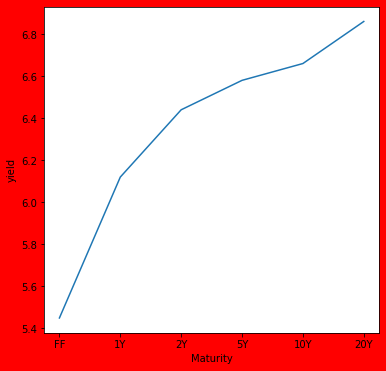

In [7]:
fig = plt.figure(figsize=(6,6),facecolor='r')
plt.plot(Yield.iloc[240,:])
plt.ylabel('yield')
plt.xlabel('Maturity')
#fig.savefig('Nelson.png')

## 主成分_revised

### 検討事項
1. 全てのデータを使って標準化している。（訓練データのみのfitが良いか）

2. 主成分間違ってはいないはずだがこれで良いか？（寄与率おかしい？）
もしかしたら1988ぐらいからの方が良いかも？

3. 評価基準がRMSE(回帰した方が自然か？）

In [8]:
Yield__=Yield.iloc[:,2:]
Yield_NT=Yield__.values[216:]

In [9]:
#標準正規化
#これ本当は訓練データのみか？
scaler1=StandardScaler()
Yield__std=scaler1.fit_transform(Yield_NT)
Yield__std[5]

array([1.67792546, 1.594862  , 1.43177476, 1.25606739])

In [10]:
#fig = plt.figure(figsize=(5,5),facecolor='y')
#plt.plot(Yield__std[:,3])
#plt.show

In [11]:
#PCAを行う
pca1=PCA(n_components=3)
pca1.fit(Yield__std)
Yield__pca=pca1.transform(Yield__std)
#pca1.fit(Yield_NT)
#Yield__pca=pca1.transform(Yield_NT)

In [12]:
#主成分(行が主成分を表す)
#Yield__pca

#主成分を導出する際の係数（各説明変数に掛け算）
#pca1.components_

#計算の確認
#I=pca1.components_[0]@Yield__std[0].T
#I
#lはYield__pcaの[0,0]に一致しているはず

#累積寄与率の計算
np.cumsum(pca1.explained_variance_ratio_)
#標準化していないと分析がうまく行っている。これは（期間を短くした？)

#因子負荷率
#pca1.components_ * np.sqrt(pca1.explained_variance_)[:, np.newaxis]
#第一主成分はどれも関係ありそう(水準,傾斜(傾き),曲率)

array([0.93718427, 0.99783005, 0.99970978])

In [13]:
Yield__pca.shape

(267, 3)

In [14]:
pca1.components_

array([[ 0.48562021,  0.51225558,  0.51129092,  0.49025384],
       [ 0.68516223,  0.23194791, -0.27647659, -0.63270339],
       [ 0.52079862, -0.62265333, -0.33171104,  0.48066559]])

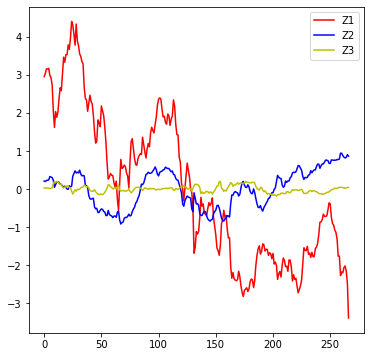

In [15]:
#主成分=ファクターの推移
fig = plt.figure(figsize=(6,6),facecolor='w')

plt.plot(Yield__pca[:,0],color='r',label='Z1')
plt.plot(Yield__pca[:,1],color='b',label='Z2')
plt.plot(Yield__pca[:,2],color='y',label='Z3')
plt.legend(loc='best')
plt.show()

fig.savefig('factor.png')

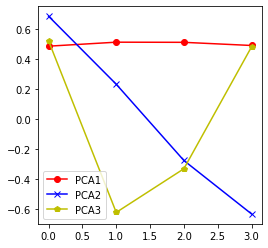

In [16]:
#各年代の債券物の相関をみる
fig = plt.figure(figsize=(4,4),facecolor='w')

plt.plot(pca1.components_[0],color='r',label='PCA1',marker='o')
plt.plot(pca1.components_[1],color='b',label='PCA2',marker='x')
plt.plot(pca1.components_[2],color='y',label='PCA3',marker='p')
#plt.ylim([-1.0,1.0])
plt.legend(loc='best')
plt.show()

In [17]:
#fig = plt.figure(figsize=(6,6),facecolor='w')

#plt.plot(pca1.components_[:,0],color='r',label='PCA1',marker='o')
#plt.plot(pca1.components_[:,1],color='b',label='PCA2',marker='x')
#plt.plot(pca1.components_[:,2],color='y',label='PCA3',marker='p')
#plt.ylim([-1.0,1.0])
#plt.legend(loc='best')
#plt.show()

In [18]:
#標準偏差と平均を格納する
STD=Yield_NT.std(axis=0)
MEAN=Yield_NT.mean(axis=0)
MEAN,STD

(array([2.39011236, 2.99363296, 3.59018727, 4.12955056]),
 array([1.86533175, 1.58406623, 1.33387792, 1.32990432]))

In [19]:
#面倒だからcsvファイルを作った。
#Yield__stdall=pd.DataFrame(Yield__std)
#Yield__stdall.head()
#Yield__stdall.to_csv('yield_std_all.csv',index=False)

In [20]:
#評価基準はRMSE
#ただ決定係数のやつでやるべきか？

Yield_tea=pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/yield_std_all.csv',header=None).values
B1=Yield__pca
def optimize(l):
  li=list()
  for L in l:
    S2=np.array([[1],[(1-math.exp(-(2)*(L)))/(2)*(L)],[(1-math.exp(-(2)*(L)))/(2)*(L)-math.exp(-(2)*(L))]])
    S5=np.array([[1],[(1-math.exp(-(5)*(L)))/(5)*(L)],[(1-math.exp(-(5)*(L)))/(5)*(L)-math.exp(-(5)*(L))]])
    S10=np.array([[1],[(1-math.exp(-(10)*(L)))/(10)*(L)],[(1-math.exp(-(10)*(L)))/(10)*(L)-math.exp(-(10)*(L))]])
    S20=np.array([[1],[(1-math.exp(-(20)*(L)))/(20)*(L)],[(1-math.exp(-(20)*(L)))/(20)*(L)-math.exp(-(20)*(L))]])
    F2=B1@S2
    F5=B1@S5
    F10=B1@S10
    F20=B1@S20
    F=np.concatenate((F2,F5,F10,F20),axis=0)

    m=(Yield_tea-F)
    M=m.T@m
    #li.append(M.values[0]/B1.shape[0])
    li.append(np.sqrt(M.values[0]/B1.shape[0]))
    #li.append(M.values[0])
  return li

In [21]:
#Yield_tea=pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/yield_std_all.csv',header=None).values
#Yield_tea=Yield_tea[140:]
#B1.shape

In [22]:
##scipyで最適化を解く
##RMSE最小化するlamdaを求める。
B=Yield__pca

def nelson(lam):
    S2=np.array([[1],[(1-math.exp(-(2*12)*(lam)))/((2*12)*(lam))],[((1-math.exp(-(2*12)*(lam)))/((2*12)*(lam)))-math.exp(-(2*12)*(lam))]])
    S5=np.array([[1],[(1-math.exp(-(5*12)*(lam)))/((5*12)*(lam))],[((1-math.exp(-(5*12)*(lam)))/((5*12)*(lam)))-math.exp(-(5*12)*(lam))]])
    S10=np.array([[1],[(1-math.exp(-(10*12)*(lam)))/((10*12)*(lam))],[((1-math.exp(-(10*12)*(lam)))/((10*12)*(lam)))-math.exp(-(10*12)*(lam))]])
    S20=np.array([[1],[(1-math.exp(-(20*12)*(lam)))/((20*12)*(lam))],[((1-math.exp(-(20*12)*(lam)))/((20*12)*(lam)))-math.exp(-(20*12)*(lam))]])

    N2=B@S2
    N5=B@S5
    N10=B@S10
    N20=B@S20
    N=np.concatenate((N2,N5,N10,N20),axis=1)

    r=(Yield_NT-N) #どちらも
    #r=(Yield__std-N) #標準化にPCAをかけたときのみ
    rm=r*r

    RM=np.sum(rm,axis=1)
    MSE=RM / float(Yield_NT.shape[1])

    #RMSE=np.sqrt(MSE)
    #SUM=np.sum(RMSE)
    SUM=np.sum(MSE)
    return SUM

    #決定係数の和で決める
    #result1=r2_score(Yield_NT[120:,0],N[:,0])
    #result2=r2_score(Yield_NT[120:,1],N[:,1])
    #result3=r2_score(Yield_NT[120:,2],N[:,2])
    #result4=r2_score(Yield_NT[120:,3],N[:,3])

    #return result1+result2+result3+result4

In [23]:
A=nelson(0.00456)
#B=np.sqrt(A)

In [24]:
#最小化問題を解く
theta_opt = sp.optimize.fmin_bfgs(f=nelson,x0=0.05)
print(theta_opt)

         Current function value: 3072.747673
         Iterations: 4
         Function evaluations: 212
         Gradient evaluations: 67
[0.04563611]


In [25]:
def nelsonver1(lam):
    S2=np.array([[1],[(1-math.exp(-(2*12)*(lam)))/((2*12)*(lam))],[((1-math.exp(-(2*12)*(lam)))/((2*12)*(lam)))-math.exp(-(2*12)*(lam))]])
    S5=np.array([[1],[(1-math.exp(-(5*12)*(lam)))/((5*12)*(lam))],[((1-math.exp(-(5*12)*(lam)))/((5*12)*(lam)))-math.exp(-(5*12)*(lam))]])
    S10=np.array([[1],[(1-math.exp(-(10*12)*(lam)))/((10*12)*(lam))],[((1-math.exp(-(10*12)*(lam)))/((10*12)*(lam)))-math.exp(-(10*12)*(lam))]])
    S20=np.array([[1],[(1-math.exp(-(20*12)*(lam)))/((20*12)*(lam))],[((1-math.exp(-(20*12)*(lam)))/((20*12)*(lam)))-math.exp(-(20*12)*(lam))]])

    N2=B@S2
    N5=B@S5
    N10=B@S10
    N20=B@S20
    N=np.concatenate((N2,N5,N10,N20),axis=1)
    return N

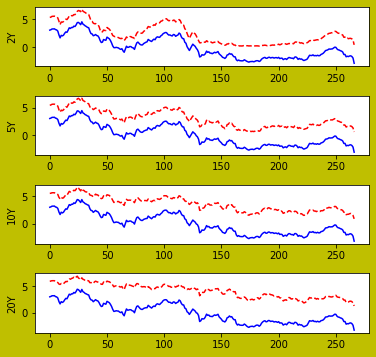

In [26]:
test = nelsonver1(0.04563)
test.shape

#fig = plt.figure(figsize=(4,4),facecolor='w')
#plt.plot(test[:,0],'b') #ネルソンシーゲルの値
#plt.plot(Yield__std[:,0],'r--')#実測値

#plt.show()

fig = plt.figure(figsize=(6,6),facecolor='y')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)

  #### 標準化したものにPCAをかけたもの ####(普通の値との二乗誤差)
  #### 普通の利回りと比較 ####
  plt.plot(Yield_NT[:,i],'r--')
  #plt.plot(Yield__std[:,i],'r--')#実測値
  plt.plot(test[:,i],'b')#ネルソン・シーゲルの値
  plt.ylabel(Yield__.columns[i])

  #### 標準化せずにPCAをかけたもの ####
  #### 標準化しなかった利回りと比較
  #plt.plot(Yield_NT[:,i],'r--')#実測値
  #plt.plot(test[:,i],'b')#ネルソン・シーゲルの値
  #plt.ylabel(Yield__.columns[i])

plt.show()

fig.savefig('Nelson-appendix.png')
## マイナスもあるよ

In [27]:
test[246:].shape


(21, 4)

In [28]:
### イールドカーブの当てはまりをみる ###
### 各月のRMSE-(2年・5年・10年・20年の二乗誤差) / 4 のルート

r=(Yield_NT[246:]-test[246:])
rm=r*r
SE=np.sum(rm,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

## 指標は73となった。見た感じ当てはまりが悪い。 ##

(array([3.32478417, 3.31820484, 3.28234738, 3.25223918, 3.25487067,
        3.31474764, 3.35318255, 3.36449066, 3.39155816, 3.40891817,
        3.44653693, 3.55514809, 3.54928436, 3.6359284 , 3.6136847 ,
        3.63475819, 3.6131602 , 3.60981629, 3.6371807 , 3.69632084,
        3.93092812]), 73.18809024702901)

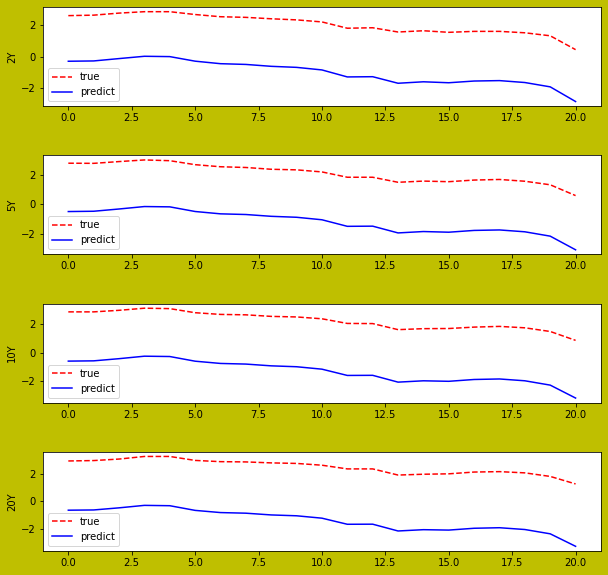

In [29]:
fig = plt.figure(figsize=(10,10),facecolor='y')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)
  plt.plot(Yield_NT[246:,i],'r--' ,label='true')#実測値
  plt.plot(test[246:,i],'b-',label='predict')#予測値
  plt.ylabel(Yield__.columns[i])
  plt.legend(loc='best')
plt.show()

fig.savefig('Nelson.png')

In [30]:
r=(Yield_NT[246:]-test[246:]) #参考:標準化したデータとの比較
rm=r*r
RM=np.sum(rm,axis=0) #列つまり債券で総和をとった場合
MSE=RM/B.shape[0]
#RMSE=math.sqrt(MSE)
#RMSE
MSE,MSE.mean()

(array([0.7382073 , 0.86033838, 1.02647638, 1.2059792 ]), 0.9577503137355359)

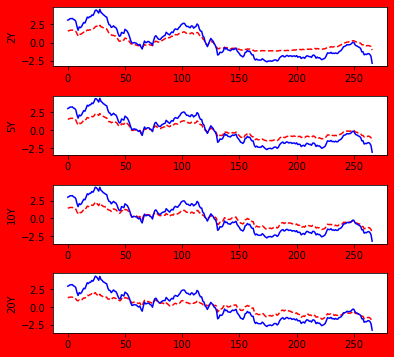

In [31]:
fig = plt.figure(figsize=(6,6),facecolor='r')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)

  
  ### 標準化をどちらも戻してやった ###
  #plt.plot((Yield__std[:,i]*STD[i])+MEAN[i],'r--')#実測値
  #plt.plot((test[:,i]*STD[i])+MEAN[i],'b')#ネルソン・シーゲルの値
  #plt.ylabel(Yield__.columns[i])

  
  ### 標準化したものと比較 ###
  plt.plot(Yield__std[:,i],'r--')#実測値
  plt.plot(test[:,i],'b')#ネルソン・シーゲルの値
  plt.ylabel(Yield__.columns[i])

plt.show()

## 状態空間モデル

#### 主成分分析(Yield_pca=B)で出る主成分3つが、水準・傾斜・曲率を表している。

#### 時系列（つまりダイナミックなネルソン・シーゲル）で変化している。

$\beta_{0,t},\beta_{1,t},\beta_{2,t}$とマクロ変数で国債の利回りを予測してみる。

In [32]:
#主成分(列名が主成分)
B0=B[:,[0]]#水準
B1=B[:,[1]]#傾き
B2=B[:,[2]]#曲率

Macro1=Macro.iloc[216:]
#1998年からのデータを適用する。

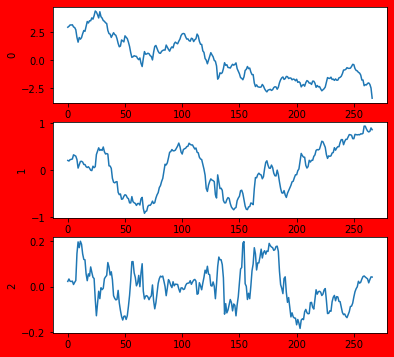

In [33]:
fig = plt.figure(figsize=(6,6),facecolor='r')
for i in range(3):
  plt.subplot(3,1,i+1)
  plt.plot(B[:,i])
  plt.ylabel(i)

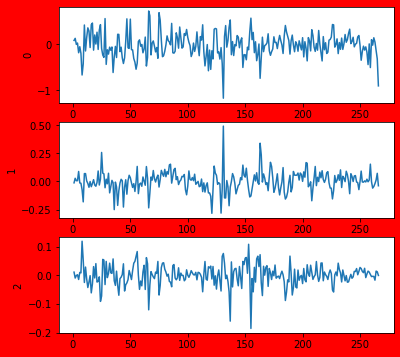

In [34]:
fig = plt.figure(figsize=(6,6),facecolor='r')
for i in range(3):
  plt.subplot(3,1,i+1)
  plt.plot(pd.DataFrame(B[:,i]).diff())
  plt.ylabel(i)

In [35]:
#単位根仮定
from statsmodels.tsa import stattools
#ADF検定
for i in range(B.shape[1]):
  adf = stattools.adfuller(B[:,i],regression="c")
  if adf[1] > 0.05:
    print(i)
    print('帰無仮説は棄却できず、単位根過程である')
  else :
    print(i)
    print('帰無仮説を棄却し、単位根過程ではない')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0
帰無仮説は棄却できず、単位根過程である
1
帰無仮説は棄却できず、単位根過程である
2
帰無仮説を棄却し、単位根過程ではない


In [36]:
#説明変数(Macro変数)描画（時系列では同じだから）
#fig = plt.figure(figsize=(16,16),facecolor='w')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
#1998年からのデータを適用する。
Macro1=Macro.iloc[216:]

#for i in range(22):
#  plt.subplot(5,5,i+1)
#  plt.plot(Macro1.iloc[:,i].values)
#  plt.ylabel(Macro1.columns[i],fontsize=12)

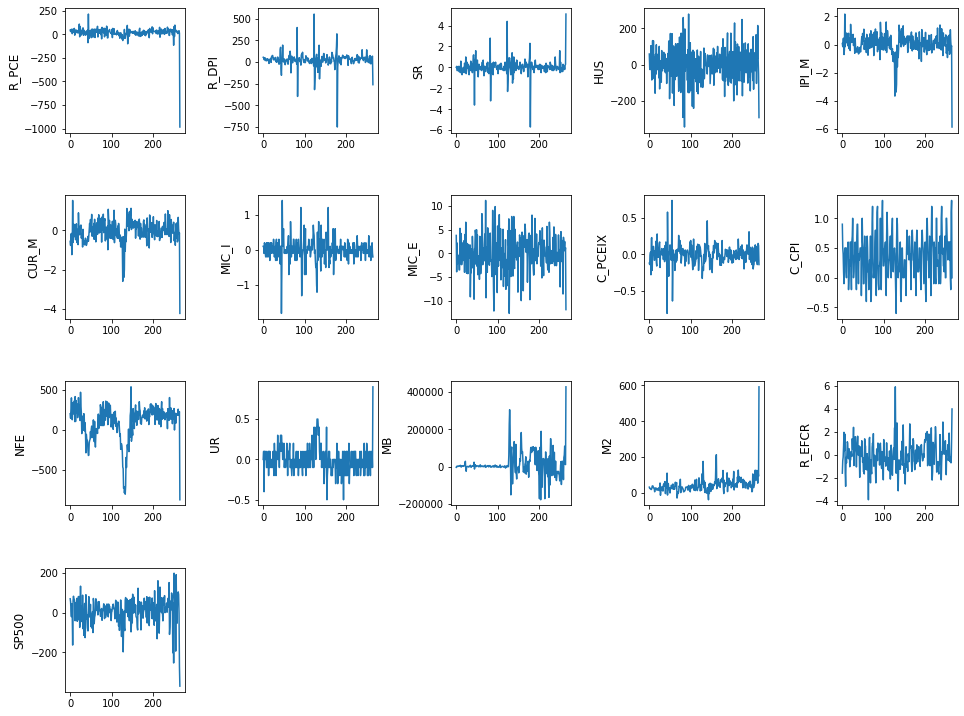

In [37]:
#Macro2 = Macro1.diff().dropna()
Macro2_nc = Macro1.iloc[:,[0,1,2,3,4,5,7,8,10,11,13,14,15,16,17,18]]
Macro2v = (Macro2_nc).diff().dropna()
#1次階差

fig = plt.figure(figsize=(16,16),facecolor='w')
fig.subplots_adjust(hspace=0.5, wspace=0.6)
for i in range(16):
  plt.subplot(5,5,i+1)
  plt.plot(Macro2v.iloc[:,i].values)
  plt.ylabel(Macro2v.columns[i],fontsize=12)

In [38]:
#Macro3 = Macro1.diff().diff().dropna()
#2次階差

#fig = plt.figure(figsize=(16,16),facecolor='w')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
#for i in range(22):
#  plt.subplot(5,5,i+1)
#  plt.plot(Macro3.iloc[:,i].values)
#  plt.ylabel(Macro3.columns[i],fontsize=12)

In [39]:
#単位根仮定
#from statsmodels.tsa import stattools
#ADF検定
#for i in range(Macro2.shape[1]):
#  adf = stattools.adfuller(Macro2.iloc[:,i],regression="ctt")
#  if adf[1] > 0.05:
#    print(Macro2.columns[i])
#    print('帰無仮説は棄却できず、単位根過程ではない')
#  else :
#    print(Macro2.columns[i])
#    print('帰無仮説を棄却し、単位根過程である')

In [40]:
#単位根仮定
#from statsmodels.tsa import stattools
#ADF検定
#for i in range(Macro3.shape[1]):
#  adf = stattools.adfuller(Macro3.iloc[:,i],regression="ctt")
#  if adf[1] > 0.05:
#    print(Macro3.columns[i])
#    print('帰無仮説は棄却できず、単位根過程ではない')
#  else :
#    print(Macro3.columns[i])
#    print('帰無仮説を棄却し、単位根過程である')

## 状態空間モデル（PCA分析全期間対象）

#### 検討事項

1. FF金利を含めるか・含めないか
2. 時変係数のRegression

In [41]:
Yield_all = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/allbond_yield.csv' , index_col=0)
#ここもしかしたらいらないかも？

Yield_all.index = pd.date_range('1980-1-1', periods=Yield_all.shape[0],freq='M')
Yield_all.columns

Index(['FF', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'], dtype='object')

In [42]:
#Yield_all[240:-2].tail()
#2020-3まで

In [43]:
#マクロ経済変数について少しやる
#できなかったのでシンプルにマクロも加えてやることにする。
Macro1=Macro.iloc[:,[0,9,13,14,17,18]]
#実質個人消費,総合価格指数,実質為替レート,S&P500,
Macro1=(Macro1.diff()/Macro1.shift(1))[1:] * 100


Macro_1=Macro1.iloc[239:,0]
Macro_2=Macro1.iloc[239:,1]
Macro_3=Macro1.iloc[239:,2]
Macro_4=Macro1.iloc[239:,3]
Macro_5=Macro1.iloc[239:,4]
Macro_6=Macro1.iloc[239:,5]

In [44]:
#30年債券についても含める
#2000年からのものを採用
Yield_all=Yield_all[240:-2].values
scaler2=StandardScaler()
Yield__std2=scaler2.fit_transform(Yield_all)
Yield__std2.shape

(243, 11)

In [45]:
pca2=PCA(n_components=3)
pca2.fit(Yield__std2)
Yield__pca2=pca2.transform(Yield__std2)

In [46]:
Yield__pca2[:10]

array([[ 7.96076169, -0.66197093, -0.30649332],
       [ 8.00698026, -0.20639773, -0.43750957],
       [ 7.80981492,  0.08082077, -0.31041442],
       [ 7.49275449,  0.33693163, -0.18690559],
       [ 8.25571407,  0.05062001, -0.27906157],
       [ 7.73020984,  0.34929527, -0.0453961 ],
       [ 7.62157806,  0.44865947,  0.08971114],
       [ 7.34881181,  0.84816462,  0.03516464],
       [ 7.24806788,  0.73229601,  0.18256578],
       [ 7.09506595,  0.7850208 ,  0.32780914]])

In [47]:
#主成分(列名が主成分を表す)
#Yield__pca2

#主成分を導出する際の係数（各説明変数に掛け算）
#pca2.components_

#計算の確認
#I=pca1.components_[0]@Yield__std[0].T
#I
#lはYield__pcaの[0,0]に一致しているはず

#累積寄与率の計算
np.cumsum(pca2.explained_variance_ratio_)

#因子負荷率
#pca2.components_ * np.sqrt(pca2.explained_variance_)[:, np.newaxis]
#第一主成分はどれも関係ありそう(水準,傾斜(傾き),曲率)

array([0.88397458, 0.99058085, 0.99789117])

In [48]:
#因子負荷量の導出
pca2.components_ * np.sqrt(pca2.explained_variance_)[:, np.newaxis]
#第一主成分はどれも関係ありそう(水準,傾斜(傾き),曲率)

array([[ 9.34429148e-01,  9.40811420e-01,  9.45588362e-01,
         9.57499445e-01,  9.79251620e-01,  9.90260242e-01,
         9.92066547e-01,  9.74799916e-01,  9.41417695e-01,
         8.58073441e-01,  8.35546098e-01],
       [ 3.26830845e-01,  3.33261992e-01,  3.26700326e-01,
         2.91924353e-01,  1.93362260e-01,  1.00876312e-01,
        -7.99056468e-02, -2.12402222e-01, -3.40978059e-01,
        -5.09773056e-01, -5.40814696e-01],
       [ 1.38960259e-01,  7.70087713e-02,  4.69744022e-02,
        -7.45882487e-04, -7.77892659e-02, -1.12947091e-01,
        -1.11204356e-01, -8.14870065e-02, -1.47414045e-02,
         7.18968496e-02,  1.00484526e-01]])

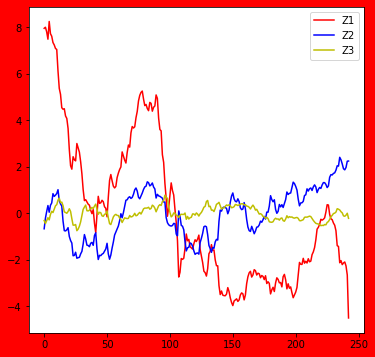

In [49]:
#主成分=ファクターの推移
fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(Yield__pca2[:,0],color='r',label='Z1')
plt.plot(Yield__pca2[:,1],color='b',label='Z2')
plt.plot(Yield__pca2[:,2],color='y',label='Z3')
plt.legend(loc='best')
plt.show()

fig.savefig('factor.png')

#### 主成分分析（ファクターの推移）
$\beta_{0,t},\beta_{1,t},\beta_{2,t}$の推移を見てみる。

$\beta_{0,t}$が表すのは水準であり、低下傾向。

$\beta_{1,t}$が表すのは傾斜であり、上昇傾向。

In [50]:
###状態空間モデル
###説明変数として主成分3つを用いる
#主成分(列名が主成分)
B0=Yield__pca2[:,[0]]#水準
B1=Yield__pca2[:,[1]]#傾き
B2=Yield__pca2[:,[2]]#曲率

#被説明変数(2年債券,5年債券,10年債券,20年債券)
Yield_test=Yield_all[:,[4,5,7,8]]

###データセットの準備
df_train=Yield_test[:222]
df_test=Yield_test[222:]

Lt_train=B0[:222]
Lt_test=B0[222:]

St_train=B1[:222]
St_test=B1[222:]

Ct_train=B2[:222]
Ct_test=B2[222:]

df_test.shape

(21, 4)

In [51]:
B0.std(),B1.std()

(3.1182880588110184, 1.0828983787031077)

#### 状態空間モデル（時変係数に係数あり）

$y_{t} = w_{0,t}*\beta_{0,t} + w_{1,t}*\beta_{1,t} + w_{2,t}*\beta_{2,t} + \epsilon_{t}$ ,$\epsilon_{t}$~$(0,H_{t})$

$w_{t} = \rho*w_{t-1} + v_{t-1}$ ,$v_{t}$~$(0,q_t)$

上の状態方程式が3つの係数について存在する。

ベクトル表記はごちゃごちゃするのでやらない。

In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [53]:
A=np.zeros((2,20))
A[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [54]:
## 状態方程式
## 
class TVRegressionrho(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, Lt, St, Ct):#####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）
        exog = np.c_[Lt, St, Ct]#####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）
        # shaped nobs x 3(マクロ経済変数を含めたら7)

        super(TVRegressionrho, self).__init__(endog=y_t, exog=exog, k_states=3,#####ここ3->23（説明変数の数）に増やす
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1

        self.ssm['design'] = exog.T[np.newaxis, :, :] # shaped 1 x 3 x nobs
        self.ssm['design',0,0,:] = 1
        self.ssm['selection'] = np.eye(self.k_states)  
        self.ssm['transition'] = np.eye(self.k_states)

       

        #Which parameters need to be positive?
        #誤差の推定なので、二乗誤差の値が負にならないようにという意味ではないだろうか？
        #self.positive_parameters = slice(0, 4)
        self.positive_parameters = slice(0, 3)
        ##self.positive_parameters = slice(0, 7)


    @property
    def param_names(self):
        
        #return ['var.e', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff', 'rho0', 'rho1', 'rho2']
        return ['var.e', 'var.St.coeff', 'var.Ct.coeff', 'rho0', 'rho1', 'rho2']
        #return ['var.e', 'var.St.coeff', 'var.Ct.coeff', 'rho1', 'rho2']
        
        #####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.params[0], res.scale, 1, 0.001, 0.0001, 0.1, 0.1, 0.1]
        #params = np.r_[res.scale, 0, 10, 10, 1, 1.2, 1.2]
        params = np.r_[res.scale, 20, 20, 1.2, 1.2, 1.2]
        #params = np.r_[res.scale, 20, 20, 1.2, 1.2]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

#    def update(self, params, **kwargs):
#        params = super(TVRegression, self).update(params, **kwargs)
#
#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:5])

    def update(self, params, **kwargs):
        params = super(TVRegressionrho, self).update(params, **kwargs)

        
        #self['obs_cov', 0, 0] = params[0]     
        #self['state_cov'] = np.diag(params[1:4])
        #self['transition', 0, 0] = params[4]
        #self['transition', 1, 1] = params[5]
        #self['transition', 2, 2] = params[6]

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = 0     
        self['state_cov', 1,1] = params[1]
        self['state_cov', 2,2] = params[2]
        self['transition', 0, 0] = params[3]
        self['transition', 1, 1] = params[4]
        self['transition', 2, 2] = params[5]

        #self['obs_cov', 0, 0] = params[0]
        #self['state_cov', 0, 0] = 0     
        #self['state_cov', 1,1] = params[1]
        #self['state_cov', 2,2] = params[2]
        #self['transition', 0, 0] = 1
        #self['transition', 1, 1] = params[3]
        #self['transition', 2, 2] = params[4]

        #Ltが含まれる
        #self['obs_cov', 0, 0] = params[0]
        #self['state_cov', 0, 0] = 0     
        #self['state_cov', 1,1] = params[2]
        #self['state_cov', 2,2] = params[3]
        #self['transition', 0, 0] = 1 #params[4]
        #self['transition', 1, 1] = params[5]
        #self['transition', 2, 2] = params[6]

##        self['obs_cov'] = np.diag(params[0:4])     
##        self['state_cov'] = np.diag(params[4:7])
##        self['transition', 0, 0] = params[7]
##        self['transition', 1, 1] = params[8]
##        self['transition', 2, 2] = params[9]

In [55]:
mod_revise = TVRegressionrho(df_train[:,0], Lt_train, Ct_train, St_train)#####被説明変数＋説明変数23こいれる
#mod2 = TVRegressionrho(Yield_test[:,1], B0, B1, B2)
#mod3 = TVRegressionrho(Yield_test[:,2], B0, B1, B2)
#mod4 = TVRegressionrho(Yield_test[:,3], B0, B1, B2)

res_revise = mod_revise.fit(maxtier=2000)

print(res_revise.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                 -63.730
Date:                Fri, 13 Nov 2020   AIC                            145.461
Time:                        07:19:39   BIC                            176.085
Sample:                             0   HQIC                           157.825
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0068      0.003      2.301      0.021       0.001       0.013
var.St.coeff     0.1480      0.039      3.812      0.000       0.072       0.224
var.Ct.coeff     0.1017      0.011      9.54

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


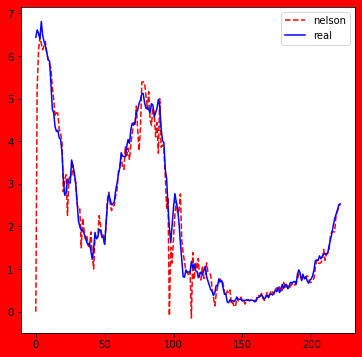

In [56]:
predict = res_revise.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict.predicted_mean,'r--' , label='nelson')

plt.plot(df_train[:,0],'b' ,label='real')
plt.legend(loc='best')
plt.show()

In [57]:
#res_revise.smoothed_state.T[10:40]

In [58]:
#時変係数の算出
b1= res_revise.smoothed_state.T[10:,0]
b1[1:10]

array([5.71847313, 5.63508583, 5.55291448, 5.47194137, 5.39214901,
       5.31352019, 5.23603794, 5.15968555, 5.08444653])

In [59]:
mod1 = TVRegressionrho(Yield_test[:,0], B0, B1, B2)#####被説明変数＋説明変数23こいれる
mod2 = TVRegressionrho(Yield_test[:,1], B0, B1, B2)
mod3 = TVRegressionrho(Yield_test[:,2], B0, B1, B2)
mod4 = TVRegressionrho(Yield_test[:,3], B0, B1, B2)

res1 = mod1.fit(maxiter=2000)
res2 = mod2.fit(maxiter=2000)
res3 = mod3.fit(maxiter=2000)
res4 = mod4.fit(maxiter=2000)



##推定結果の保存
#ss = pd.DataFrame(res.smoothed_state.T, columns=['Lt', 'St','Ct'])

#mod = TVRegressionrho(Yield_test, B0, B1, B2)#####被説明変数＋説明変数23こいれる
#res = mod.fit(maxiter=2000)

print(res1.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  243
Model:                TVRegressionrho   Log Likelihood                 -74.930
Date:                Fri, 13 Nov 2020   AIC                            167.860
Time:                        07:19:41   BIC                            199.298
Sample:                             0   HQIC                           180.523
                                - 243                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0079      0.003      2.860      0.004       0.002       0.013
var.St.coeff     0.0873      0.009      9.787      0.000       0.070       0.105
var.Ct.coeff     0.1512      0.037      4.07

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
predict1=res1.predict()
predict2=res2.predict()
predict3=res3.predict()
predict4=res4.predict()

r1=Yield_test[222:,0]-predict1[222:]
r2=Yield_test[222:,1]-predict2[222:]
r3=Yield_test[222:,2]-predict3[222:]
r4=Yield_test[222:,3]-predict4[222:]

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()
#rm,r1

(array([0.44700114, 0.47898298, 0.53885607, 0.76133102, 0.58601038,
        0.5238235 , 0.4133462 , 0.41333624, 0.34071259, 0.30788263,
        0.2540099 , 0.1432263 , 0.09621332, 0.59680306, 0.0761245 ,
        0.07529961, 0.0664776 , 0.04050898, 0.02970481, 0.18681989,
        1.16787347]), 7.544344209574956)

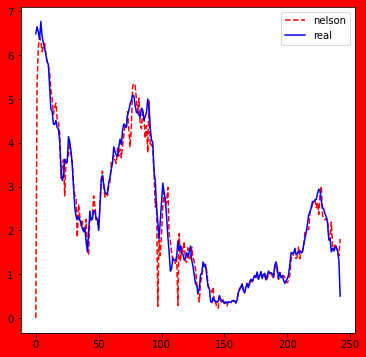

In [61]:
##推定と予測
##predict 推定具合
predict = res2.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict.predicted_mean,'r--' , label='nelson')

plt.plot(Yield_test[:,1],'b' ,label='real')
plt.legend(loc='best')
plt.show()

In [62]:
####テスト
###三次元配列になっている
###exog1 = np.c_[B0, B1, B2]
###exog = np.array([exog1,exog1,exog1,exog1])
###exog.shape

In [63]:
r=(Yield_test[222:,0]-predict.predicted_mean[222:])
rm=r*r
#SE=np.sum(rm,axis=1)
#MSE=SE
RMSE=np.sqrt(rm)
RMSE,RMSE.sum()

(array([0.07824702, 0.12188661, 0.1302191 , 0.4931214 , 0.04106637,
        0.3293556 , 0.20033098, 0.23690116, 0.16980556, 0.06538783,
        0.02772495, 0.07454895, 0.07043532, 0.61917474, 0.04920998,
        0.0166047 , 0.08962047, 0.02038233, 0.00428497, 0.09097449,
        1.35452802]), 4.283810543158235)

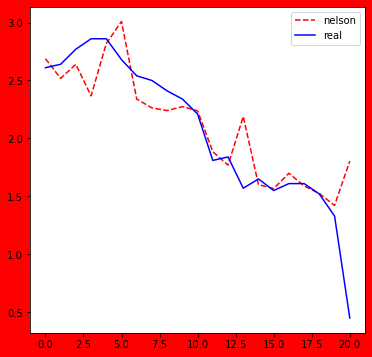

In [64]:
#nelson-siegelモデルのテスト期間での計測

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict.predicted_mean[222:],'r--',label='nelson') ##予測値
plt.plot(Yield_test[222:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

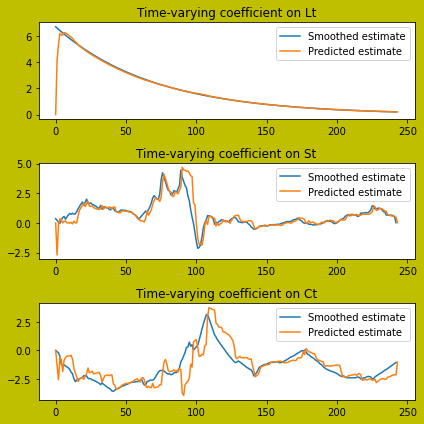

In [65]:
fig, axes = plt.subplots(3, figsize=(6, 6),facecolor='y')

ss = pd.DataFrame(res1.smoothed_state.T, columns=['Lt', 'St','Ct'])
sspre=pd.DataFrame(res1.predicted_state.T,columns=['Lt','St','Ct'])

#axes[0].plot(beta_x, label='True')
axes[0].plot(ss['Lt'], label='Smoothed estimate')
axes[0].plot(sspre['Lt'], label='Predicted estimate')
axes[0].set(title='Time-varying coefficient on Lt')
#axes[0].set_ylim([0,3])
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['St'], label='Smoothed estimate')
axes[1].plot(sspre['St'], label='Predicted estimate')
axes[1].set(title='Time-varying coefficient on St')
axes[1].legend()

axes[2].plot(ss['Ct'],label='Smoothed estimate')
axes[2].plot(sspre['Ct'], label='Predicted estimate')
axes[2].set(title='Time-varying coefficient on Ct')
axes[2].legend()

fig.tight_layout();


#### 状態空間モデル(観測方程式にマクロ経済変数を組み込む）

In [66]:
## 状態方程式
## マクロ経済の変数を組み込んだもの。
##ボツですね。

class TVRegressionrho(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, Lt, St, Ct , Mt_1, Mt_2, Mt_3, Mt_4, Mt_5, Mt_6):#####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）
        exog = np.c_[Lt, St, Ct, Mt_1, Mt_2, Mt_3, Mt_4, Mt_5, Mt_6]
        #####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）
        # shaped nobs x 3(マクロ経済変数を含めたら7)

        super(TVRegressionrho, self).__init__(endog=y_t, exog=exog, k_states=9,#####ここ3->23（説明変数の数）に増やす
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1

        self.ssm['design'] = exog.T[np.newaxis, :, :] # shaped 1 x 3 x nobs
        ##A=np.array([exog.T,exog.T,exog.T,exog.T])
        ##self.ssm['design'] = A
        self.ssm['selection'] = np.eye(self.k_states)  
        self.ssm['transition'] = np.eye(self.k_states)

       

        #Which parameters need to be positive?
        #誤差の推定なので、二乗誤差の値が負にならないようにという意味ではないだろうか？
        self.positive_parameters = slice(0, 10)
        ##self.positive_parameters = slice(0, 7)


    @property
    def param_names(self):
        #return ['intercept', 'var.e', 'var.b_0t.coeff', 'var.b_1t.coeff', 'var.b_2t.coeff','rho0','rho1','rho2']
        return ['var.e', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff', 'var.Mt_1.coeff', 'var.Mt_2.coeff', 'var.Mt_3.coeff', 
                'var.Mt_4.coeff', 'var.Mt_5.coeff', 'var.Mt_6.coeff', 'rho0', 'rho1', 'rho2', 'rho3', 'rho4', 'rho5', 'rho6', 'rho7', 'rho8']
        ##return ['var.e_2', 'var.e_5', 'var.e_10', 'var.e_20', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff', 'rho0', 'rho1', 'rho2']
        #####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.params[0], res.scale, 1, 0.001, 0.0001, 0.1, 0.1, 0.1]
        params = np.r_[res.scale, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        ##params = np.r_[1, 1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1,0.01]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

#    def update(self, params, **kwargs):
#        params = super(TVRegression, self).update(params, **kwargs)
#
#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:5])

    def update(self, params, **kwargs):
        params = super(TVRegressionrho, self).update(params, **kwargs)

#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:4])
#        self['transition', 0, 0] = params[4]
#        self['transition', 1, 1] = params[5]

        
        self['obs_cov', 0, 0] = params[0]     
        self['state_cov'] = np.diag(params[1:10])
        self['transition', 0, 0] = params[10]
        self['transition', 1, 1] = params[11]
        self['transition', 2, 2] = params[12]
        self['transition', 3, 3] = params[13]
        self['transition', 4, 4] = params[14]
        self['transition', 5, 5] = params[15]
        self['transition', 6, 6] = params[16]
        self['transition', 7, 7] = params[17]
        self['transition', 8, 8] = params[18]

##        self['obs_cov'] = np.diag(params[0:4])     
##        self['state_cov'] = np.diag(params[4:7])
##        self['transition', 0, 0] = params[7]
##        self['transition', 1, 1] = params[8]
##        self['transition', 2, 2] = params[9]

In [67]:
mod_M = TVRegressionrho(Yield_test[:,0], B0, B1, B2, Macro_1, Macro_2, Macro_3, Macro_4, Macro_5, Macro_6)#####被説明変数＋説明変数23こいれる
res_M = mod_M.fit(maxiter=5000)

##推定結果の保存
ss = pd.DataFrame(res_M.smoothed_state.T, columns=['Lt', 'St','Ct','PCE','T_PCEIX','Emp','UR','R_EFCR','S&P500'])

#mod = TVRegressionrho(Yield_test, B0, B1, B2)#####被説明変数＋説明変数23こいれる
#res = mod.fit(maxiter=2000)

print(res_M.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  243
Model:                TVRegressionrho   Log Likelihood                 -76.798
Date:                Fri, 13 Nov 2020   AIC                            209.596
Time:                        07:19:48   BIC                            307.402
Sample:                             0   HQIC                           248.991
                                - 243                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
var.e           5.394e-05      0.009      0.006      0.995      -0.018       0.018
var.Lt.coeff       0.0045      0.001      4.578      0.000       0.003       0.006
var.St.coeff       0.0219      0.007

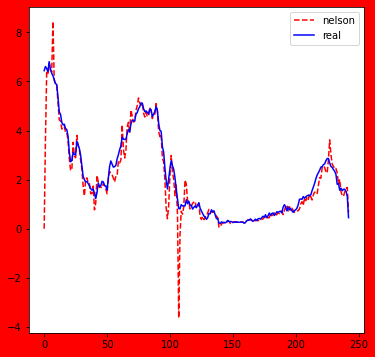

In [68]:
##推定と予測
##predict 推定具合
predict_M = res_M.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict_M.predicted_mean,'r--' , label='nelson')

plt.plot(Yield_test[:,0],'b' ,label='real')
plt.legend(loc='best')
plt.show()

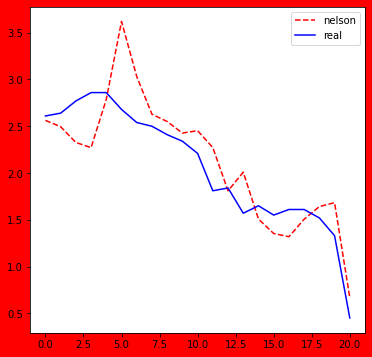

In [69]:
fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict_M.predicted_mean[222:],'r--',label='nelson') ##予測値
plt.plot(Yield_test[222:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

In [70]:
r=(Yield_test[222:,0]-predict_M.predicted_mean[222:])
rm=r*r
#SE=np.sum(rm,axis=1)
#MSE=SE
RMSE=np.sqrt(rm)
RMSE,RMSE.sum()

(array([0.04715052, 0.14490846, 0.44341337, 0.58879771, 0.07249876,
        0.9404345 , 0.49230264, 0.12848506, 0.14074283, 0.08725123,
        0.24281756, 0.46168691, 0.03013379, 0.43860144, 0.14228764,
        0.19688571, 0.29131634, 0.1044089 , 0.12120451, 0.35292969,
        0.21712624]), 5.685383814578175)

In [71]:
ss = pd.DataFrame(res_M.smoothed_state.T)
sspre=pd.DataFrame(res_M.predicted_state.T)

#### 状態空間モデル（時変係数に係数なし）

In [116]:
#状態方程式

class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, Lt, St, Ct):
        exog = np.c_[Lt, St, Ct]  # shaped nobs x 3

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=3,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 3 x nobs
        self.ssm['design',0,0,:] = 1
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Which parameters need to be positive?
        self.positive_parameters = slice(0, 3)

    @property
    def param_names(self):
        #return ['var.e', 'var.b_0t.coeff', 'var.b_1t.coeff','var.b_2t.coeff']
        return ['var.e', 'var.St.coeff', 'var.Ct.coeff']
        #return ['var.e', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.scale, 0.001, 0.001, 0.001]
        params = np.r_[res.scale, 10, 10]
        #params = np.r_[10, 100, 100]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained


    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:4])

        self['obs_cov', 0, 0] = params[0]
        #self['state_cov'] = np.diag(params[1:4])
        self['state_cov',0,0] = 0
        self['state_cov',1,1] = params[1]
        self['state_cov',2,2] = params[2] 

In [73]:
mod1 = TVRegression(Yield_test[:,[2]], B0, B1, B2)
res1 = mod1.fit()

print(res1.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  243
Model:                   TVRegression   Log Likelihood                -225.749
Date:                Fri, 13 Nov 2020   AIC                            463.497
Time:                        07:19:48   BIC                            484.455
Sample:                             0   HQIC                           471.939
                                - 243                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0756      0.013      6.012      0.000       0.051       0.100
var.St.coeff     0.1196      0.018      6.516      0.000       0.084       0.156
var.Ct.coeff     1.0807      0.185      5.84

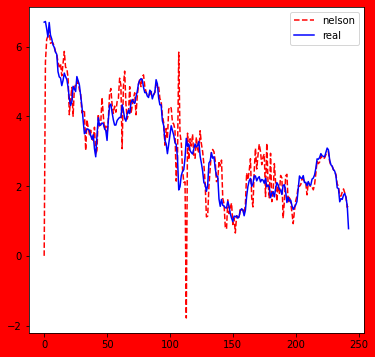

In [74]:
##状態方程式の係数なし
##get_predictionで行う。（予測）AICは219

A1 = res1.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(A1.predicted_mean,'r--',label='nelson') ##予測値
plt.plot(Yield_test[:,2],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

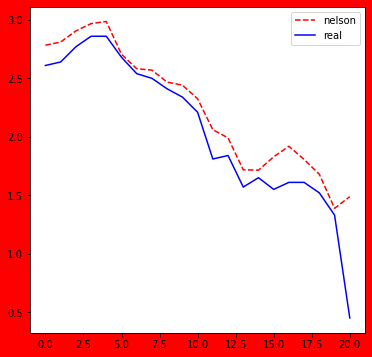

In [75]:
fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(A1.predicted_mean[222:],'r--',label='nelson') ##予測値
plt.plot(Yield_test[222:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

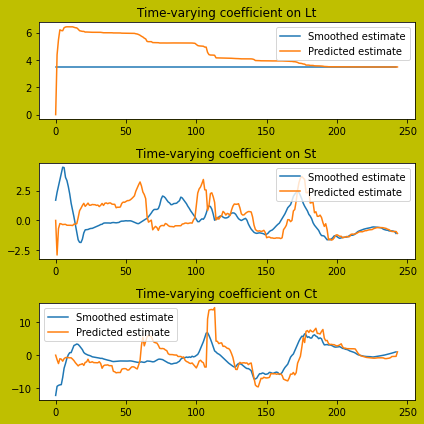

In [76]:
fig, axes = plt.subplots(3, figsize=(6, 6),facecolor='y')

ss = pd.DataFrame(res1.smoothed_state.T, columns=['Lt', 'St','Ct'])
sspre = pd.DataFrame(res1.predicted_state.T,columns=['Lt','St','Ct'])

#axes[0].plot(beta_x, label='True')
axes[0].plot(ss['Lt'], label='Smoothed estimate')
axes[0].plot(sspre['Lt'], label='Predicted estimate')
axes[0].set(title='Time-varying coefficient on Lt')
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['St'], label='Smoothed estimate')
axes[1].plot(sspre['St'], label='Predicted estimate')
axes[1].set(title='Time-varying coefficient on St')
axes[1].legend(loc='best')

axes[2].plot(ss['Ct'],label='Smoothed estimate')
axes[2].plot(sspre['Ct'], label='Predicted estimate')
axes[2].set(title='Time-varying coefficient on Ct')
axes[2].legend(loc='best')

fig.tight_layout();

In [117]:
mod2 = TVRegression(df_train[:,0],Lt_train,St_train,Ct_train)
mod5 = TVRegression(df_train[:,1],Lt_train,St_train,Ct_train)
mod10 = TVRegression(df_train[:,2],Lt_train,St_train,Ct_train)
mod20 = TVRegression(df_train[:,3],Lt_train,St_train,Ct_train)

y2 = mod2.fit(maxtier=3000)
y5 = mod5.fit(maxtier=3000)
y10 = mod10.fit(maxtier=3000)
y20 = mod20.fit(maxtier=3000)

ss2 = y2.smoothed_state.T
ss5 = y5.smoothed_state.T
ss10 = y10.smoothed_state.T
ss20 = y20.smoothed_state.T

In [119]:
###回帰予測をしてみる
###時変係数の推定
np.random.seed(10)
lt = ss2[:,0].mean()#Ltの係数
st_std = np.random.normal(0,0.1903,(21))
ct_std = np.random.normal(0,1.7365,(21))

st = ss2[-1,1] + st_std[0]
ct = ss2[-1,2] + st_std[0]

In [120]:
def make_design_matrix(step,estm_std,first_param):
    st_std = np.random.normal(0,(estm_std[0])**0.5,(step))
    ct_std = np.random.normal(0,(estm_std[1])**0.5,(step))

    li_st = list()
    li_ct = list()
    st_first = first_param[0] + st_std[0]
    ct_first = first_param[1] + st_std[0]
    li_st.append(st_first)
    li_ct.append(ct_first)

    for i in range(1,step):
      st = li_st[i-1] + st_std[i]
      ct = li_ct[i-1] + ct_std[i]
      li_st.append(st)
      li_ct.append(ct)

    st = np.array(li_st)
    ct = np.array(li_ct)

    return st,ct

In [125]:
upd_st2,upd_ct2 = make_design_matrix(21,(0.1903,1.7365),(ss2[-1,1],ss2[-1,2]))
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt
kore = kore[np.newaxis,:,:]

dy2 = {'design': kore}

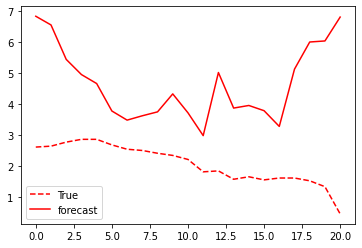

In [126]:
forecas = y2.get_forecast(steps=21,dynamic=True,**dy2)
ci = forecas.conf_int()

#plt.plot(forecas)
fig = plt.figure(facecolor='w')
plt.plot(df_test[:,0],'r--',label='True')
plt.plot(forecas.predicted_mean,'r', label='forecast')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='best')
plt.show()

In [82]:
A=np.array([[[1,2],[3,4]],[[5,6],[7,8]]])
A.shape
A[0,0,:]=1

In [83]:
np.c_[np.array(range(20)),np.repeat(1, 20)]
np.r_[np.array(range(20)),np.repeat(1, 20)]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [84]:
starting_values = {'Ct_coeff':2.5,'St_coeff':0.09,'var_e': 5,'var_Lt': B0.std(), 'var_St':B1.std(),'var_Ct':B2.std()}
#starting_values = {'Lt_coeff':1,'Ct_coeff':10,'St_coeff':5,'var_e': 5,'var_Lt': 20, 'var_St':10,'var_Ct':2}
#starting_values = {'var_e': 20,'var_Lt': 100, 'var_St':40,'var_Ct':10}

import collections
from collections import OrderedDict


class YieldModel(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t):

        #exog = np.c_[s_t, np.repeat(1, len(s_t))]  # exog.shape => (nobs, 2)

        super(YieldModel, self).__init__(endog=y_t, k_states=3,initialization='diffuse')

        #self.ssm['design'] = np.ones((self.k_endog, self.k_states, self.nobs))
        self.ssm['design'] = np.ones((self.k_endog,self.k_states))
        self.ssm['design',0,0] = 1

        #These have ok shape. Placeholders since I'm changing them
        #in the update() function
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Dictionary of positions to names
        #self.position_dict = OrderedDict(var_e=1, var_Lt=2,var_St=3, var_Ct=4)
        #self.position_dict  = OrderedDict(Lt_coeff=1,St_coeff=2,Ct_coeff=3,var_e=4,var_Lt=5,var_St=6,var_Ct=7)
        self.position_dict  = OrderedDict(St_coeff=1,Ct_coeff=2,var_e=3,var_Lt=4,var_St=5,var_Ct=6)
        self.initial_values = starting_values
        #self.positive_parameters = slice(0,4)
        #self.positive_parameters = slice(3,7)
        self.positive_parameters = slice(2,6)


    @property
    def param_names(self):
        return list(self.position_dict.keys())

    @property
    def start_params(self):
        """
        Initial values
        """
        #(optional) Use scale for var_e1 and var_e2 starting values
        #params = np.r_[self.initial_values['var_e'],
        #               self.initial_values['var_Lt'],
        #               self.initial_values['var_St'],
        #               self.initial_values['var_Ct']]
        #params = np.r_[self.initial_values['Lt_coeff'],
        #               self.initial_values['St_coeff'],
        #               self.initial_values['Ct_coeff'],
        #               self.initial_values['var_e'],
        #               self.initial_values['var_Lt'],
        #               self.initial_values['var_St'],
        #               self.initial_values['var_Ct']]
        params = np.r_[self.initial_values['St_coeff'],
                       self.initial_values['Ct_coeff'],
                       self.initial_values['var_e'],
                       self.initial_values['var_Lt'],
                       self.initial_values['var_St'],
                       self.initial_values['var_Ct']]
        return params

    def transform_params(self, unconstrained):
        """
        If you need to restrict parameters
        For example, variances should be > 0
        Parameters maybe have to be within -1 and 1
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to reverse what you did in transform_params()
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(YieldModel, self).update(params, **kwargs)

        #The following line is not needed (by default, this matrix is initialized by zeroes),
        #But I leave it here so the dimensions are clearer
        self['design',0,0]=1
        self['design',0,1]=params[0] #1
        self['design',0,2]=params[1] #2

        #self['obs_cov',0,0] = params[0]
        self['obs_cov',0,0] = params[2] #3

        #self['state_cov'] = np.diag(params[1:4])
        self['state_cov'] = np.diag(params[3:6]) #4:7

In [85]:
cus = YieldModel(df_train[:,0])
res = cus.fit(maxiter=5000)

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                     YieldModel   Log Likelihood                  46.475
Date:                Fri, 13 Nov 2020   AIC                            -74.950
Time:                        07:19:50   BIC                            -44.326
Sample:                             0   HQIC                           -62.586
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
St_coeff      -0.0102     98.253     -0.000      1.000    -192.582     192.561
Ct_coeff   -8.485e-05      0.819     -0.000      1.000      -1.606       1.606
var_e       1.946e-11      0.002   9.87e-09      1.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2220: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)


In [86]:
ss = pd.DataFrame(res.predicted_state.T, columns=['Z1', 'Z2','Z3'])

ss.head()

,Z1,Z2,Z3
0,0.000000,0.000000,0.000000
1,6.439333,-0.065541,-0.000546
2,6.608841,-0.113821,-0.000589
3,6.529073,-0.091101,-0.000569
4,6.399448,-0.054181,-0.000536


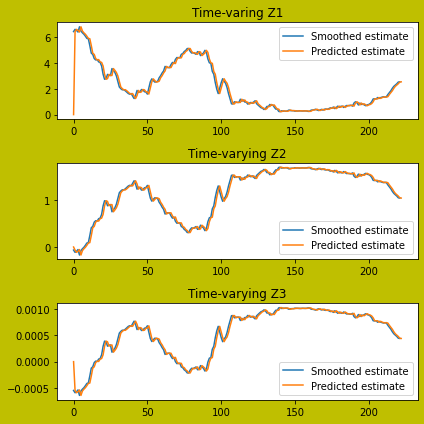

In [87]:
fig, axes = plt.subplots(3, figsize=(6, 6),facecolor='y')

ss = pd.DataFrame(res.smoothed_state.T, columns=['Z1', 'Z2','Z3'])
sspre = pd.DataFrame(res.predicted_state.T, columns=['Z1', 'Z2','Z3'])

#axes[0].plot(beta_x, label='True')
axes[0].plot(ss['Z1'], label='Smoothed estimate')
axes[0].plot(sspre['Z1'], label='Predicted estimate')
axes[0].set(title='Time-varing Z1')
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['Z2'], label='Smoothed estimate')
axes[1].plot(sspre['Z2'], label='Predicted estimate')
axes[1].set(title='Time-varying Z2')
axes[1].legend()

axes[2].plot(ss['Z3'],label='Smoothed estimate')
axes[2].plot(sspre['Z3'], label='Predicted estimate')
axes[2].set(title='Time-varying Z3')
axes[2].legend()

fig.tight_layout();

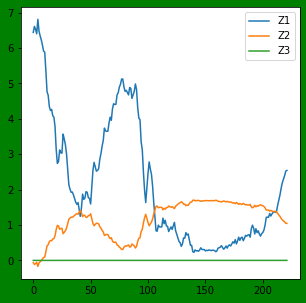

In [88]:
fig = plt.figure(figsize=(5,5),facecolor='g')
plt.plot(ss['Z1'],label='Z1')
plt.plot(ss['Z2'],label='Z2')
plt.plot(ss['Z3'],label='Z3')
plt.legend(loc='best')
plt.show()

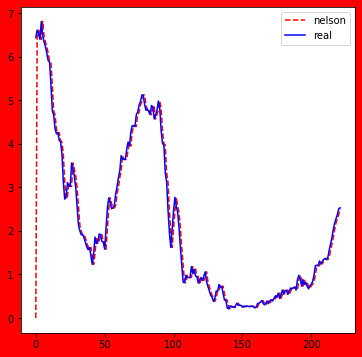

In [89]:
A1 = res.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(A1.predicted_mean,'r--',label='nelson') ##予測値
plt.plot(df_train[:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

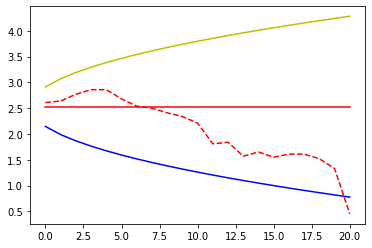

In [90]:
forecas = res.get_forecast(steps=21)
ci = forecas.conf_int()

#plt.plot(forecas)
fig = plt.figure(facecolor='w')
plt.plot(forecas.predicted_mean,'r', label='forecast')
plt.plot(df_test[:,0], 'r--')
plt.plot(ci[:,0],'b')
plt.plot(ci[:,1],'y')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1995: ValueWarning: Model has time-invariant design matrix, so the design argument to `predict` has been ignored.
  warn(warning % (name, name), ValueWarning)


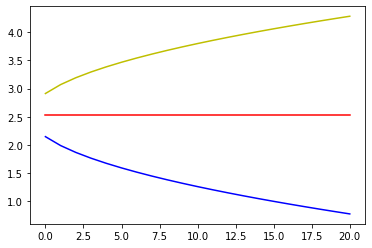

In [91]:
a={'design':np.random.randn(1,3,10)}
#forecas=res.get_forecast(steps=30)

forecas = res.get_forecast(steps=21,dynamic=True,**a)
ci = forecas.conf_int()

#plt.plot(forecas)
fig = plt.figure(facecolor='w')
plt.plot(forecas.predicted_mean,'r', label='forecast')
plt.plot(ci[:,0],'b')
plt.plot(ci[:,1],'y')
plt.show()

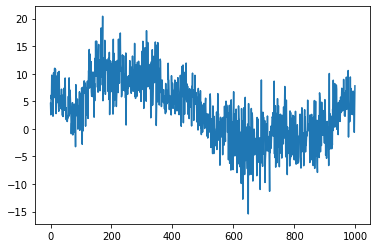

In [92]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    d = 5
    var_y = 5
    var_coeff_x = 0.01
    var_coeff_w = 0.5

    x_t = rs.uniform(size=nobs)
    w_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y**0.5, size=nobs)

    beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x**0.5))
    beta_w = np.cumsum(rs.normal(size=nobs, scale=var_coeff_w**0.5))

    y_t = d + beta_x * x_t + beta_w * w_t + eps
    return y_t, x_t, w_t, beta_x, beta_w

y_t, x_t, w_t, beta_x, beta_w = gen_data_for_model1()
_ = plt.plot(y_t)

In [93]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 4)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])

In [94]:
mod = TVRegression(y_t, x_t, w_t)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -2336.846
Date:                Fri, 13 Nov 2020   AIC                           4685.692
Time:                        07:19:52   BIC                           4715.139
Sample:                             0   HQIC                          4696.884
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0548      0.202     25.050      0.000       4.659       5.450
var.e           5.1240      0.249     20.571      0.000       4.636       5.612
var.x.coeff     0.0468      0.022      2.097    

## 主成分分析ボツ

In [95]:
#Yield__=Yield.iloc[:,2:]
#Yield__=Yield__.values

In [96]:
#Yield改データ

#Yield_=Yield.iloc[:,2:]
#Yield_T=Yield_.values.T

#Yield1=pd.DataFrame(Yield_T,columns=Yield_.index,index=Yield_.columns)
#Yield1.reindex(Yield_.columns)
#Yield1.head()

In [97]:
#一応訓練データと検証用データに分けておく。
#data_split=int(Yield1.shape[1] * 0.7)
#Yield_train=Yield1.iloc[:,:data_split]
#Yield_test=Yield1.iloc[:,data_split:]
#Yield_train.shape

In [98]:
#主成分分析だけみるなら、全てにやっても大丈夫
#scaler=StandardScaler()
#Yield_std=scaler.fit_transform(Yield1)
#Yield_std.shape

In [99]:
#pca=PCA(n_components=4)
#pca.fit(Yield_std)
#Yield_pca=pca.transform(Yield_std)

In [100]:
#Yield_pca

In [101]:
#PCa=pd.DataFrame(Yield_pca)
#PCa.shape

In [102]:
#主成分の累積寄与率
#np.cumsum(pca.explained_variance_ratio_)

In [103]:
#主成分の係数
#pca.components_
#1行目が第1主成分,2行目が第２主成分,3行目が第3主成分,4行目が第4主成分#

In [104]:
#固有値
#pca.explained_variance_

In [105]:
#pca.components_ * np.sqrt(pca.explained_variance_)[:, np.newaxis]

In [106]:
#fig = plt.figure(figsize=(6,6),facecolor='w')

#plt.plot(pca.components_[0],color='r',label='PCA1')
#plt.plot(pca.components_[1],color='b',label='PCA2')
#plt.plot(pca.components_[2],color='y',label='PCA3')
#plt.ylim([-1.0,1.0])
#plt.legend(loc='best')
#plt.show()

## ボツ

In [107]:
#a-Maturity,Lm-param
#1980年代当初のイールドカーブ推定
import math
def nelson_test(a,L):
  #a=a*12
  B0=Yield__pca[0,0]
  B1=Yield__pca[0,1]
  B2=Yield__pca[0,2]
  #B=(Yield__pca[124,0])*(a)+(Yield__pca[124,1])*((1-math.exp(-(a)*(L)))/L)+(Yield__pca[124,2])*(((1-math.exp(-(a)*(L)))/L)-(a)*(math.exp(-(a)*(L))))
  #B=(Yield__pca[0,0])+(Yield__pca[0,1] + Yield__pca[0,2])*(1-math.exp(-(a)/(L)))*(L)/(a)-(Yield__pca[0,2])*math.exp(-(a)/(L))
  #日銀の論文を参照している。
  Ft=B0+(B1+B2)*(1-math.exp((a)*(L)))/((a)*(L))-(B2)*(math.exp(-((a)*(L))))
  return Ft

In [108]:
#標準偏差と平均を格納する
#STD=Yield.std().values[2:]
#MEAN=Yield.mean().values[2:]
#MEAN,STD

In [109]:
#print(nelson_test(20,0.0005))
#print(Yield__std[0,3],Yield_NT[0,3])

In [110]:
#S=MEAN[2]+(nelson_test(120,0.001))*(STD[2])
#print(math.sqrt((Yield_NT[0,2]-S)**2))
#print(math.sqrt((Yield__std[0,2]-nelson_test(10,0.001))**2))

In [111]:
#nelsonの値を格納した配列を返す
#def nelson(r,M):
  #a=a*12
  #li=list()
  #それぞれの満期にてfittingしたものを計算する
  #for m in M:
    #for s in range(0,Yield__pca.shape[0]):
      #B0=Yield__pca[s,0]
      #B1=Yield__pca[s,1]
      #B2=Yield__pca[s,2]
  #B=(Yield__pca[124,0])*(a)+(Yield__pca[124,1])*((1-math.exp(-(a)*(L)))/L)+(Yield__pca[124,2])*(((1-math.exp(-(a)*(L)))/L)-(a)*(math.exp(-(a)*(L))))
  #B=(Yield__pca[0,0])+(Yield__pca[0,1] + Yield__pca[0,2])*(1-math.exp(-(a)/(L)))*(L)/(a)-(Yield__pca[0,2])*math.exp(-(a)/(L))
  #日銀の論文を参照している。
      #Ft=B0+(B1+B2)*(1-math.exp((m)*(r)))/((m)*(r))-(B2)*(math.exp(-((m)*(r))))
      #li.append(Ft)
#  Ft = np.array(li)
#  return Ft
  #return li

In [112]:
#更に改築(ラムダごとに列に並べる&教師データの改築)
#Yield_tea=pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/yield_std_all.csv',header=None)
#def optim(x,M):
#  lis=list()
#  for r in x:
#    cal=nelson(r,M)
#    lis.append(cal)
#  S=np.array(lis).T
#  S=pd.DataFrame(S,columns=x)
#  S1=pd.concat([S,Yield_tea],axis=1)
#  return S1

In [113]:
#標準化を戻す処理ができねえ。
#A=optim([0.0005,0.001,0.01],[2,5,10,20])
#A.head(10)

In [114]:
nsample = 100
x = np.linspace(0, 10, 100)
beta = np.array([1, 0.1])
e = np.random.normal(size=nsample)
X = sm.add_constant(x)
y_true=np.dot(X, beta)
y = y_true + e